<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 2: deep learning для обработки звука</center></h2>

# Введение

В этом задании Вы поработаете и разберетесь в деталях с форматами представления аудиоданных в задачах глубинного обучения, а так же напишете несколько моделей для классификации аудиозаписей.

В процессе выполнения Вы познакомитесь:
* С алгоритмом построения Мел-спектрограммы
* Рекуррентными и сверточными классификаторами аудиоданных
* Алгоритмом аугментации аудиоданных SpecAugment

In [1]:
!pip install torch==1.8.0 torchaudio==0.8.0 numpy==1.20.0

     |████████████████████████████████| 735.5 MB 15 kB/s 
     |████████████████████████████████| 1.9 MB 37.0 MB/s 
     |████████████████████████████████| 15.3 MB 2.3 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
torchvision 0.11.1+cu111 requires torch==1.10.0, 

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torchaudio
from IPython import display
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset


%matplotlib inline

assert torch.__version__.startswith("1.8.0")
assert torchaudio.__version__ == "0.8.0"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Классификация аудиозаписей.

В этом домашнем задании Вам предстоит классифицировать аудиозаписи из датасета [UrbanSound8K](https://urbansounddataset.weebly.com/urbansound8k.html).

Данный датасет состоит из 8732 записей, разбитых на train/val/test датасеты. 

![image](https://paperswithcode.com/media/datasets/UrbanSound8K-0000003722-02faef06.jpg)

Каждая аудиозапись содержит запись шума города и принадлежит одному из 10 классов: 

`[air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music]`


## Задание 1 (1 балл). Знакомство с данными.

1. Скачайте датасет из [Google Drive](https://drive.google.com/file/d/12emmtpodmo1783e6VOOEjV20zAKl5dZR/view?usp=sharing) c и распакуйте в папку `./data`.

2. Напишите `AudioDataset` класс, который будет принимать путь к файлам `train_part.csv` и `val_part.csv` и возращать тройки объектов `(x, y, len)`, где `x` - аудиозапись, `y` - класс аудиозаписи, `len` - длина аудиозаписи. Аудиозаписи **не должны постоянно храниться в RAM**, подгрузку _wav_ файлов надо сделать при запросе через `__getitem__` метод. Кроме того, надо сделать паддинг аудиозаписи - если она короче чем `pad_size` параметр, надо дополнять ее нулями.

3. С помощью функции `display.Audio` проиграйте в ноутбуке пару аудиозаписей.


In [ ]:
!rm -r ./data
!mkdir ./data/
!pip install gdown
!cd ./data && gdown https://drive.google.com/uc?id=12emmtpodmo1783e6VOOEjV20zAKl5dZR && unzip HW2_dataset.zip && rm HW2_dataset.zip

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=12emmtpodmo1783e6VOOEjV20zAKl5dZR 



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/ColabNotebooks/HW2_dataset.zip"

In [5]:
# классы данных
classes = [
    "air_conditioner", 
    "car_horn", 
    "children_playing", 
    "dog_bark",
    "drilling", 
    "engine_idling", 
    "gun_shot", 
    "jackhammer", 
    "siren", 
    "street_music"
]

In [6]:
class AudioDataset(Dataset):
    def __init__(
        self, 
        path_to_csv: str, 
        path_to_folder: str, 
        pad_size: int = 384000,
        sr: int = 44100,
        device = device
    ):
        self.device = device
        self.csv: pd.DataFrame = pd.read_csv(path_to_csv)[["ID", "Class"]]
        self.path_to_folder = path_to_folder
        self.pad_size = pad_size

        self.sr = sr

        self.class_to_idx = {classes[i]: i for i in range(10)}

    def right_padding_if_necessary(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.pad_size:
            num_missing_samples = self.pad_size - signal_length
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal    
    
    def __getitem__(self, index: int):
   
        output = self.csv.iloc[index]
        path, label = output
        label = classes.index(label)
        path = os.path.join(self.path_to_folder, str(path)+'.wav')

        signal, sr = torchaudio.load(path)
        #signal = signal.to(self.device)
        if sr != self.sr:
            resampler = torchaudio.transforms.Resample(sr, self.sr)
            signal = resampler(signal)
        
        length = signal.shape[1]

        signal = self.right_padding_if_necessary(signal)
        signal = signal.reshape(-1,)

        instance = {
            'x': signal,
            'y': label,
            'len': length
        }
        
        return instance
       

    def __len__(self):
        return self.csv.shape[0]

In [7]:
# создадим датасеты
train_dataset = AudioDataset("/content/urbansound8k/train_part.csv", "/content/urbansound8k/data")
val_dataset = AudioDataset("/content/urbansound8k/val_part.csv", "/content/urbansound8k/data")

In [8]:
# проверим размеры датасетов
assert len(train_dataset) == 4500
assert len(val_dataset) == 935

In [9]:
# проверим возращаемые значения __getitem__
item = train_dataset.__getitem__(0)

assert item["x"].shape == (384000, )
assert item["y"] == 0
assert item["len"] == 176400

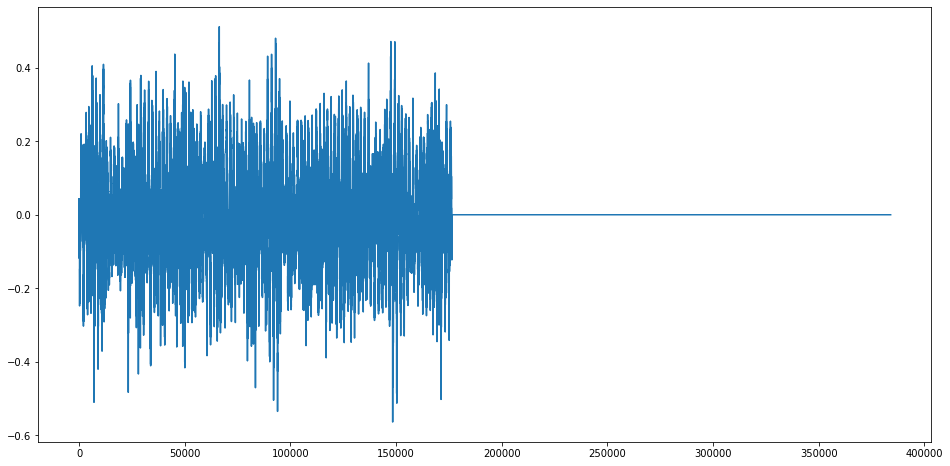

In [10]:
# нарисуем и проиграем аудиозаписить
item = train_dataset.__getitem__(0)
plt.figure(figsize=(16, 8))
plt.plot(item["x"])

display.Audio(item["x"], rate=train_dataset.sr)

In [11]:
# создадим даталоадеры
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True,
    pin_memory=True, 
    drop_last=True
)
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=32,
    pin_memory=True
)

## Задание 2. Рекуррентная сеть для классификации аудиозаписей по сырому сигналу

Обучим реккурентную сеть для классификации аудиозаписей.

1. Разбиваем аудизаписить на окошки размером `1024` с шагом `256`
2. Применим к каждому получившемуся окну аудиосигнала полносвязную сеть с активациями `ReLU` и  внутренними размерностям `(1024 -> 256 -> 64 -> 16)`.
3. По получившимся последовательностям пройдемся двунаправленой (`bidirectional=True`) LSTM с двумя слоями (`layers=2`).
4. Склеим c помощью `torch.cat` последние `hidden_state` для каждого слоя и применим к ним полносвязную сеть `(2 * hidden_size * num_layers -> 256 -> 10)` с активацией `ReLU`.

![title](./imgs/rnn_raw.png)

In [12]:
class RecurrentRawAudioClassifier(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

      

        self.first_mlp = nn.Sequential(
            nn.Linear(1024,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,16)
        )

        self.rnn = nn.LSTM(16,hidden,num_layers, bidirectional=True, batch_first = True)

        self.final_mlp = nn.Sequential(
            nn.Linear(2*hidden*num_layers,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
       

    def forward(self, x, lens) -> torch.Tensor:
        # разбиваем сигнал на окна 
        # batch_windows.shape == (B, NUM WINDOWS, 1024)

        batch_windows0 = x.unfold(1,self.window_length,self.hop_length)
        
        batch_windows = batch_windows0.reshape(batch_windows0.shape[0]*batch_windows0.shape[1],1024)

        # применим к каждому окну полносвязную сеть
        # batch_windows_feautures.shape == (B, NUM WINDOWS, 16)

        batch_windows_feautures = self.first_mlp(batch_windows).reshape(batch_windows0.shape[0],batch_windows0.shape[1],16)
       
        # применим к получившемся последовательностям LSTM и возьмите hidden state
        output, (h_n, c_n) = self.rnn(batch_windows_feautures)


        # склеим hidden_state по слоям
        # hidden_flattened.shape = (B, 2 * hidden_size * num_layers)
        hidden_flattened = torch.cat((h_n[0,:,:],h_n[1,:,:],h_n[2,:,:],h_n[3,:,:]), axis = 1)

        # применяем полносвязную сеть и получим логиты классов
        results = self.final_mlp(hidden_flattened)

        return results 

Обучим получившуюся модель.

In [13]:
def train_audio_clfr(
    model, 
    optimizer, 
    train_dataloader, 
    sr,
    criterion=torch.nn.CrossEntropyLoss(),
    data_transform=None, 
    augmentation=None,
    num_epochs=10, 
    device=device,
    verbose_num_iters=10
):
    model.train()
    iter_i = 0
    
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):  
        for batch in train_dataloader:
            x = batch["x"].to(device)
            y = batch["y"].to(device)
            lens = batch["len"].to(device)

            # применяем преобразование входных данных
            if data_transform:
                x, lens = data_transform(x, lens, device=device, sr=sr)

            # примеменяем к логмелспектрограмме аугментацию
            if augmentation:
                x, lens = augmentation(x, lens)

            probs = model(x, lens)
            optimizer.zero_grad()
            loss = criterion(probs, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # считаем точность предсказания
            pred_cls = probs.argmax(dim=-1)
            train_accuracies.append((pred_cls == y).float().mean().item())

            iter_i += 1

            # раз в verbose_num_iters визуализируем наши лоссы и семплы
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)

                print(f"Epoch {epoch}")

                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.xlabel("Iteration")
                plt.ylabel("Train loss")
                plt.plot(np.arange(iter_i), train_losses)

                plt.subplot(1, 2, 2)
                plt.xlabel("Iteration")
                plt.ylabel("Train acc")
                plt.plot(np.arange(iter_i), train_accuracies)

                plt.show()

    model.eval()

In [14]:
# создадим объекты модели и оптимизатор
rnn_raw = RecurrentRawAudioClassifier()
rnn_raw.to(device)
optim = torch.optim.Adam(rnn_raw.parameters(), lr=3e-4)

Epoch 9


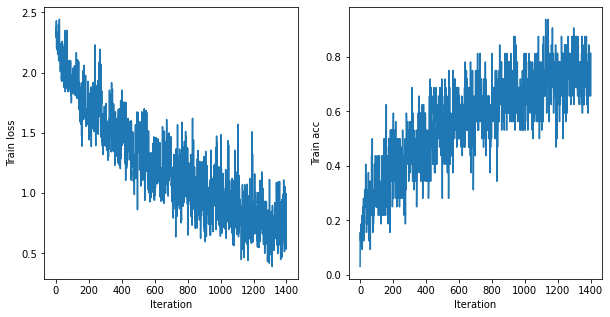

In [15]:
# обучим модель
train_audio_clfr(rnn_raw, optim, train_dataloader, train_dataset.sr, device = device)

Посчитаем метрики на валидационном датасете.

In [16]:

def plot_confusion_matrix(model, val_dataloader, sr, device, data_transform=None):
    pred_true_pairs = []
    for batch in val_dataloader:
        x = batch["x"].to(device)
        y = batch["y"].to(device)
        lens = batch["len"].to(device)

        with torch.no_grad():
            if data_transform:
                x, lens = data_transform(x, lens, sr=sr, device=device)

            probs = model(x, lens)

            pred_cls = probs.argmax(dim=-1)

        for pred, true in zip(pred_cls.cpu().detach().numpy(), y.cpu().numpy()):
            pred_true_pairs.append((pred, true))

    print(f"Val accuracy: {np.mean([p[0] == p[1] for p in pred_true_pairs])}")

    cm_df = pd.DataFrame(
        confusion_matrix(
            [p[1] for p in pred_true_pairs], 
            [p[0] for p in pred_true_pairs], 
            normalize="true"
        ),
        columns=classes, 
        index=classes
    )
    sn.heatmap(cm_df, annot=True)

Val accuracy: 0.3946524064171123


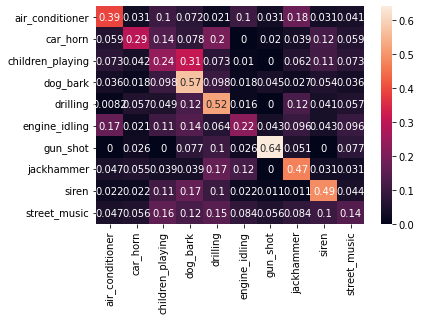

In [17]:
plot_confusion_matrix(rnn_raw, val_dataloader, train_dataset.sr, device)

Оценка качества модели на валидационной выборке ощутимо ниже, чем на тренировочной.
Это может быть связано со схожестью многих звуков. Так, звуки выстрелов оказываются часто спутываемыми с большим количеством иных звуков, что может приводить к очень высоким показателям ошибки. На тренировочной выборке возникает переобучение, однако реального различия в паттернах модель все же не находит.

## Задание 3. Построение Мел-cпектрограмм.

Сырой сигнал очень чувствителен ко многим факторам - увеличение/уменьшение громкости, внешние шумы, сменение тембра говорящего очень резко меняют сырой сигнал. Это влияет и на качество глубоких сетей, обученных на сыром аудиосигнале.

Для построения надежных и устойчивых к переобучению моделей используют другое представление аудиоданных - спектрограммы, в том числе Мел-спектрограмму.

Идея её построения заключается в следующем:
1. Сигнал разбивается на временные интервалы (с пересечениями)
2. К каждому временному интервалу применяется фильтр (как правило косинусоидальный)
3. К профильтрованному сигналу применяется дискретное преобразование Фурье и вычисляются спектральные признаки сигнала.
4. Спектральные признаки с помощью логарифмического преобразования приводятся в Мел-шкалу.

![image](https://antkillerfarm.github.io/images/img2/Spectrogram_5.png)

В этом задании мы сами шаг за шагом напишем алгоритм построения мелспектрограммы и сравнимся с референсной функцией из `torchaudio`.

In [18]:
from torchaudio.transforms import MelSpectrogram

# референсная функця
def compute_log_melspectrogram_reference(
    wav_batch, 
    lens,
    sr,
    device="cpu"
):
    featurizer = MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        win_length=1024,
        hop_length=256,
        n_mels=64,
        center=False,
        ).to(device)

    return torch.log(featurizer(wav_batch).clamp(1e-5)), lens // 256

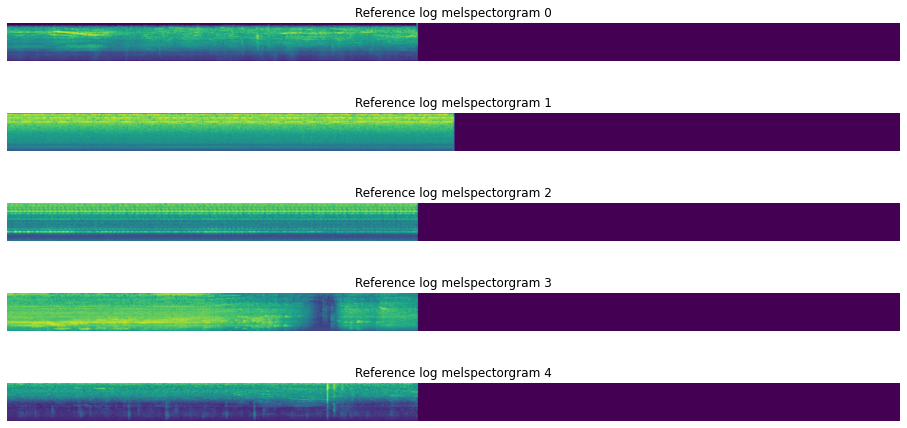

In [19]:
# возьмем случайный батч
for batch in train_dataloader:
    break

wav_batch = batch["x"]
lens = batch["len"]

# посчитаем лог мелспектрограммы
log_melspect, lens = compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)

# нарисуем получившиеся референсные значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Reference log melspectorgram {i}")
    axes[i].imshow(log_melspect[i].numpy())

Теперь сделаем то же самое сами. 

In [20]:
sr = train_dataset.sr
n_fft=1024
win_length=1024
hop_length=256
n_mels=64

In [21]:
windows = wav_batch.unfold(1,win_length,hop_length)
assert windows.shape == (32, 1497, 1024)

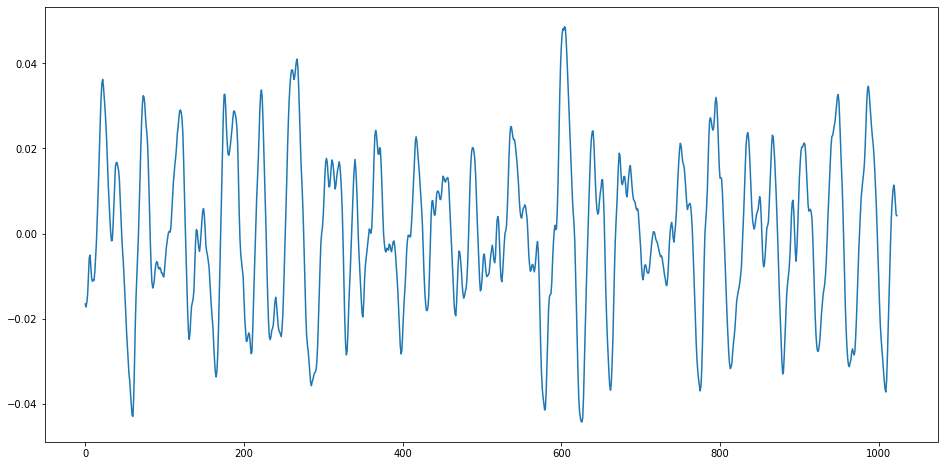

In [22]:
plt.figure(figsize=(16, 8))
plt.plot(windows[0, 0])

display.Audio(windows[0, 0], rate=train_dataset.sr)

Теперь нам надо применить косинуисальный фильтр к сигналу из окна

In [23]:
filter = torch.hann_window(win_length)
windows_with_applied_filter = windows * filter[None, None, :]

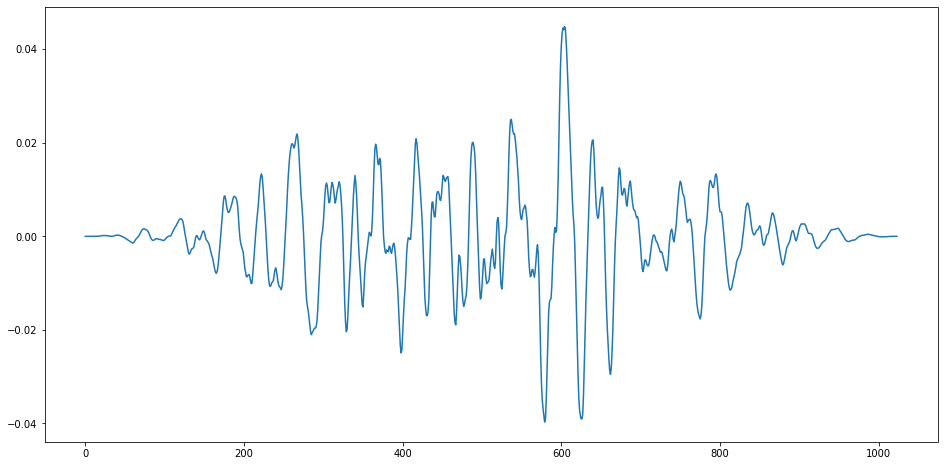

In [24]:
plt.figure(figsize=(16, 8))
plt.plot(windows_with_applied_filter[0, 0])

display.Audio(windows_with_applied_filter[0, 0], rate=train_dataset.sr)

Применим дискретное преобразование фурье к каждому окну и возьмем первые `n_fft // 2 + 1` компоненты.

Дальше с помощью возведения элементов тензора в квадрат получим магнитуды.

In [25]:
fft_features = torch.fft.fft(windows_with_applied_filter, n_fft, 2)[:,:,:n_fft//2+1]
fft_magnitudes = torch.abs(fft_features ** 2)
assert fft_magnitudes.shape == (32, 1497, 513)

In [26]:
melscale = torchaudio.transforms.MelScale(n_mels, sr, n_stft = n_fft//2+1)

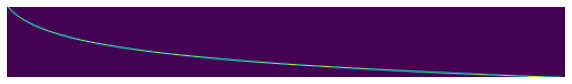

In [27]:
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.imshow(melscale.fb.numpy().transpose())

Применим Мел-шкалу к магнитудам.

In [28]:
mel_spectrogram = melscale(fft_magnitudes.transpose(1,2))
assert mel_spectrogram.shape == (32, 64, 1497)

Сделаем обрезку значений по `1e-5` и применим `torch.log` для получения логарифмированной Мел-спектрограммы.

In [29]:
logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5))
assert logmel_spectrogram.shape == (32, 64, 1497)

Полученные логарифмированные Мел-Спектрограммы должны совпадать с референсными.

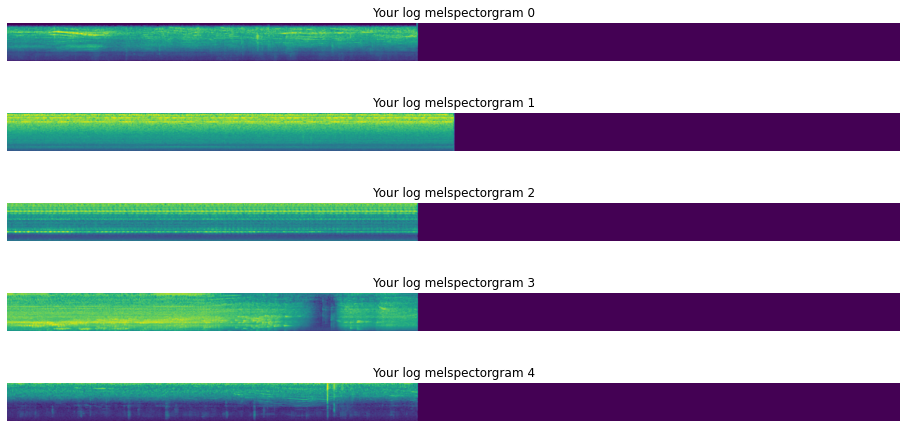

In [30]:
# нарисуем получившиеся значения
fig, axes = plt.subplots(5, figsize=(16, 8))

for i in range(5):
    axes[i].axis("off")
    axes[i].set_title(f"Your log melspectorgram {i}")
    axes[i].imshow(logmel_spectrogram[i].numpy())

Теперь оформим эту логику в функцию.

In [31]:
# ваша реализация
def compute_log_melspectrogram(
    wav_batch,
    lens,
    sr,
    device="cpu"
    ):
  
  
  windows = wav_batch.unfold(1,win_length,hop_length)
  filter = torch.hann_window(win_length)
  windows, filter = windows.to(device), filter.to(device)
  windows_with_applied_filter = windows * filter[None, None, :]
  windows_with_applied_filter.to(device)
  
  fft_features = torch.fft.fft(windows_with_applied_filter, n_fft, 2)[:,:,:n_fft//2+1]
  fft_features = fft_features.to(device)
  fft_magnitudes = torch.abs(fft_features ** 2)
  fft_magnitudes = fft_magnitudes.to(device)
  
  melscale = torchaudio.transforms.MelScale(n_mels, sr, n_stft = n_fft//2+1)
  melscale = melscale.to(device)
  mel_spectrogram = melscale(fft_magnitudes.transpose(1,2)).to(device)
  
  
  logmel_spectrogram = torch.log(mel_spectrogram.clamp(1e-5)).to(device)

  return logmel_spectrogram, lens//256


Финальная проверка.

In [32]:
assert torch.allclose(
    compute_log_melspectrogram_reference(wav_batch, lens, train_dataset.sr)[0],
    compute_log_melspectrogram(wav_batch, lens, train_dataset.sr)[0],
    atol=1e-5
)

## Задание 4. Рекуррентная сеть для классификации аудиозаписей по логарифмированным Мел-спектрограммам

Измените реализацию рекуррентной сети из задания 2, таким образом, чтобы она вместо сырого сигнала смогла принимать логарифмированные Мел-спетрограммы:

In [33]:
class RecurrentMelSpectClassifier(nn.Module):
    def __init__(
        self, 
        num_classes=10,
        window_length=1024,
        hop_length=256,
        hidden=256,
        num_layers=2
    ) -> None:
        super().__init__()

        self.window_length = window_length
        self.hop_length = hop_length

  
        self.rnn = nn.LSTM(64,hidden,num_layers, bidirectional=True, batch_first = True)

        self.final_mlp = nn.Sequential(
            nn.Linear(2*hidden*num_layers,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
  

    def forward(self, x, lens):
        
        output, (h_n, c_n) = self.rnn(x.transpose(1,2))

        hidden_flattened = torch.cat((h_n[0,:,:],h_n[1,:,:],h_n[2,:,:],h_n[3,:,:]), axis = 1)

        results = self.final_mlp(hidden_flattened)

        return results
       

In [34]:
rnn_mel = RecurrentMelSpectClassifier()
rnn_mel.to(device)

optim = torch.optim.Adam(rnn_mel.parameters(), lr=3e-4)

Epoch 9


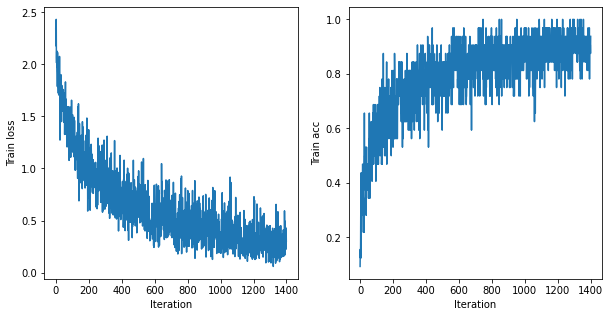

In [35]:
train_audio_clfr(rnn_mel, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram)

Посчитаем метрики на валидационном датасете.

Val accuracy: 0.8096256684491978


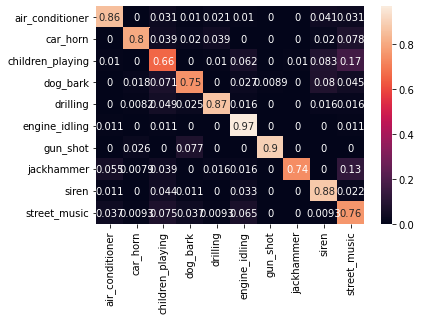

In [36]:
plot_confusion_matrix(rnn_mel, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 5. Cверточная сеть для классификации аудиозаписей по мелспектрограммам.

Легко заметить, что мелспектрограммы имеют четко выраженные паттерны - если приноровиться, то даже человек, посмотрев на мелспектрограмму, сможет _визуально_ проклассифицировать объект.

Это позволяет свести задачу классификации аудиозаписей к задаче классификации картинок.

Реализуем такую сверточную сеть:

* 2x (Conv2d 3x3 @ 16, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 32, BatchNorm2d, ReLU)
* MaxPoll 2x2
* 2x (Conv2d 3x3 @ 64, BatchNorm2d, ReLU)
* MaxPoll 2x2
* (Conv2d 3x3 @ 128, BatchNorm2d, ReLU)
* (Conv2d 2x2 @ 128, BatchNorm2d, ReLU)
* Global MaxPoll
* Fully Connected 128, ReLU
* Fully Connected 10

In [37]:
class CNN10(nn.Module):
    def __init__(self, num_classes=10, hidden=16):
        super().__init__()

     
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(1,16, kernel_size = (3,3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,16, kernel_size = (3,3)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(16,32, kernel_size = (3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,32, kernel_size = (3,3)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(32,64, kernel_size = (3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size = (3,3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),

            nn.Conv2d(64,128, kernel_size = (3,3)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size = (2,2)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.final_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128,10)
            )
        

    def forward(self, x, lens):
        z = self.cnn_backbone(x[:, None, :, :])
        z = torch.nn.functional.max_pool2d(z, kernel_size=z.size()[2:])[:, :, 0, 0]
        return self.final_mlp(z)

In [38]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


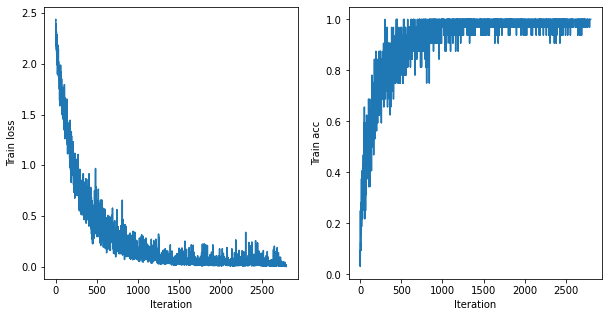

In [39]:
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 num_epochs=20)

Val accuracy: 0.9390374331550803


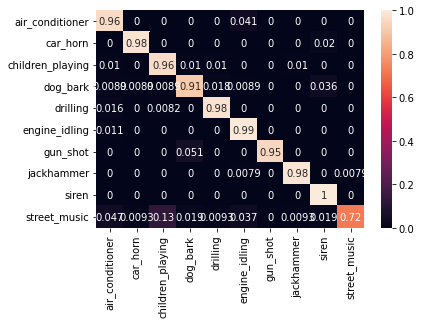

In [40]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)

## Задание 6. Аугментация SpecAugment

Обычно датасеты с аудиозаписями довольно малы. Наш датасет тому пример - всего 4500 объектов в обучающей выборке. Обучение глубокий сетей с большим кол-вом параметров на таких датасетах часто ведет к переобучению и проседанию метрик на валидационном и тестовом датасетах.

Для борьбы с переобучением имеет смысл использовать аугментацию данных. Для мелспектрограмм была придумана аугментация под названием SpecAugment.

Смысл её очень прост - зануление спектрограммы по временным промежуткам и по мел-частотам:
1. Выбираются несколько временных промежутков ${[t^1_i, t^2_i]}$ и заполняют спектрограмму $s[t^1_i : t^2_i, :]$ значением $v$.

2. Выбираются несколько промежутков мелчастот ${[m^1_i, m^2_i]}$ и заполняют спектрограмму $s[:, m^1_i : m^2_i]$ значением $v$.

В качестве значения $v$ выбирают:
1. `'mean'`: среднее по спектрограмме
2. `'min'`: минимум по спектрограмме
3. `'max'`: максимум по спектрограмме
5. `v`: некоторая константа

В этом задании Вам предлагается реализовать аугментацию SpecAugment.

In [52]:
import random


class SpectAugment:
    def __init__(
        self,
        filling_value = "mean",
        n_freq_masks = 2,
        n_time_masks = 2,
        max_freq = 10,
        max_time = 50,
    ):

        self.filling_value = filling_value
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        self.max_freq = max_freq
        self.max_time = max_time

    def __call__(self, spect, lens):
        

        spect_cop = spect.to(device).detach().clone()
        freq_l = [0,0]
        time_l = [0,0]
        ox = [0,0]
        oy = [0,0]
        filled_values = torch.full((spect_cop.shape[1], spect_cop.shape[2]), torch.mean(spect_cop[:,:,:]).item())

        for i in range (self.n_freq_masks):
          freq_l[i] = random.randint(1, self.max_freq)
          oy[i] = random.randint(1, spect_cop.shape[1])

        for j in range (self.n_time_masks):
          time_l[j] = random.randint(1, self.max_time)
          ox[j] = random.randint(1, spect_cop.shape[2])
        
        spect_cop[:,oy[i]:oy[i]+freq_l[i], ox[j]:ox[j]+time_l[j]] = filled_values[oy[i]:oy[i]+freq_l[i], ox[j]:ox[j]+time_l[j]]

        return spect_cop, lens//256
 

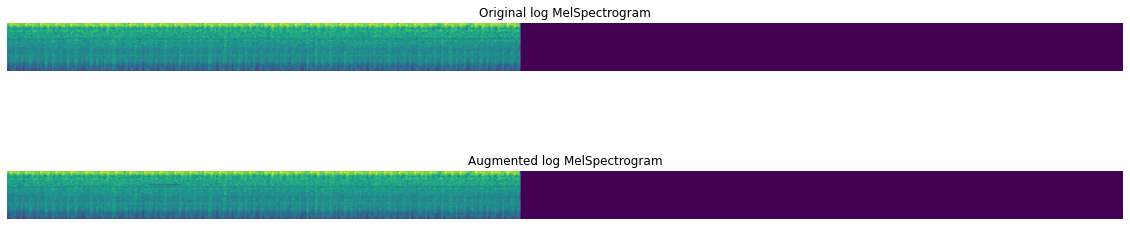

In [48]:
# применим аугментацию к данным
for batch in train_dataloader:
    break

x = batch["x"].to(device)
lens = batch["len"].to(device)
x_logmel, lens = compute_log_melspectrogram_reference(x, lens, sr=train_dataset.sr, device=device)
x_logmel_augmented, lens = SpectAugment()(x_logmel, lens)

# нарисуем спектрограмму до и после аугментации
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.title("Original log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel[0].cpu().numpy())

plt.subplot(2, 1, 2)
plt.title("Augmented log MelSpectrogram")
plt.axis("off")
plt.imshow(x_logmel_augmented[0].cpu().numpy())

plt.show()

In [49]:
cnn = CNN10()
cnn.to(device);

optim = torch.optim.Adam(cnn.parameters(), lr=3e-4)

Epoch 19


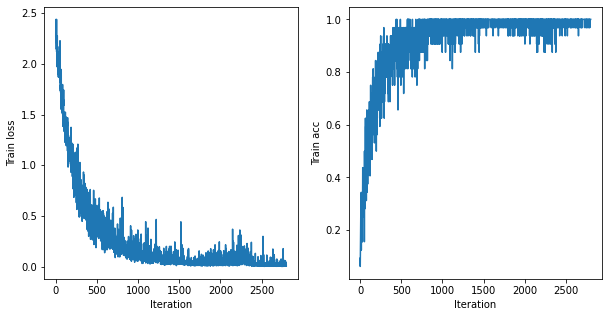

In [50]:
# обучим модель на данных с аугментациями
train_audio_clfr(cnn, optim, train_dataloader, train_dataset.sr, 
                 data_transform=compute_log_melspectrogram,
                 augmentation=SpectAugment(),
                 num_epochs=20)

Val accuracy: 0.9368983957219251


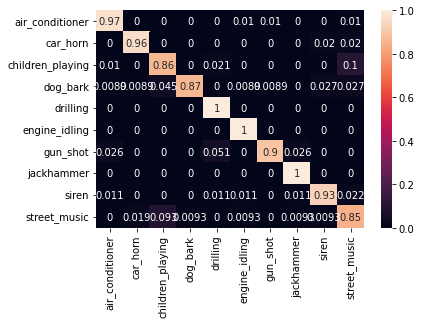

In [51]:
plot_confusion_matrix(cnn, val_dataloader, train_dataset.sr, device, 
                      data_transform=compute_log_melspectrogram)